In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import uuid

# Create mock data for A/B testing lab

1. Create date range for experiment
2. Generate random users (`anonymous_id`)
3. Distribute random users across date range (build in in-week seasonality)
4. Create subscriptions table with `user_id`s
5. Create mapping table to connect `anonymous_id`s and `user_id`s
6. Include users in experiment in subscription table

**Create date range for experiment data**

In [2]:
date_range = pd.date_range("2020-01-16", "2020-02-29")

In [3]:
experiment_start = "2020-02-01"

**Create random anonymous_ids and assign to each day**

In [4]:
def create_anonymous_ids(n: int) -> list:
    return [str(uuid.uuid4()) for i in range(n)]

def daily_users(timestamp: pd.Timestamp) -> list:
    in_week_seasonality = {0: 5.5,
                           1: 5.3,
                           2: 5,
                           3: 5,
                           4: 5,
                           5: 4,
                           6: 4}
    magnitude = 8000
    variation = .6
    factor = in_week_seasonality[timestamp.dayofweek]
    lower_bound = int((factor - variation) * magnitude)
    upper_bound = int((factor + variation) * magnitude)
    
    return create_anonymous_ids(random.randint(lower_bound, upper_bound))

def daily_users_per_variant(timestamp: pd.Timestamp) -> tuple:
    in_week_seasonality = {0: 5.5,
                           1: 5.3,
                           2: 5,
                           3: 5,
                           4: 5,
                           5: 4,
                           6: 4}
    magnitude = 1000
    variation = .6
    factor = in_week_seasonality[timestamp.dayofweek]
    lower_bound = int((factor - variation) * magnitude)
    upper_bound = int((factor + variation) * magnitude)
    
    exp_users = create_anonymous_ids(random.randint(lower_bound, upper_bound))
    random.shuffle(exp_users)

    split = int(len(exp_users) / (random.randint(1900, 2100) / 1000))
    var_a = exp_users[:split]
    var_b = exp_users[split:]
    
    return var_a, var_b
    
def insert_rows(df: pd.DataFrame,
                users: list,
                timestamp: pd.Timestamp,
                exp_id: int) -> pd.DataFrame:
    df2 = pd.DataFrame([{"date_id": timestamp,
                         "anonymous_id": visitor,
                         "exp_id": exp_id} for visitor in users])
    return pd.concat([df, df2])

In [5]:
first_pageview = pd.DataFrame(columns=["date_id", "anonymous_id", "exp_id"])

random.seed(111)
for i in date_range:
    users = daily_users(i)
    var_a, var_b = daily_users_per_variant(i)
    
    # convert to DataFrame
    first_pageview = insert_rows(first_pageview, users, i, np.nan)
    first_pageview = insert_rows(first_pageview, var_a, i, 101)
    first_pageview = insert_rows(first_pageview, var_b, i, 102)

In [6]:
first_pageview.head()

,date_id,anonymous_id,exp_id
0,2020-01-16,4d005f94-e06f-493c-b569-9efb5ce4d203,NaN
1,2020-01-16,948ad58a-f483-4007-aa56-280aa018427b,NaN
2,2020-01-16,31f4f2e4-4ae6-417b-8a6d-53b98a719145,NaN
3,2020-01-16,24747dc7-355a-44b0-95c6-0caa91cd4ae4,NaN
4,2020-01-16,0162c4f8-7bc2-4432-90b9-bfb61f5e57b3,NaN


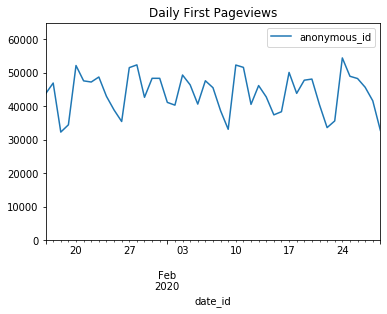

In [7]:
ax = first_pageview.groupby("date_id").agg({"anonymous_id": "count"}).plot();
ax.set_ylim((0,65000))
ax.set_title("Daily First Pageviews");

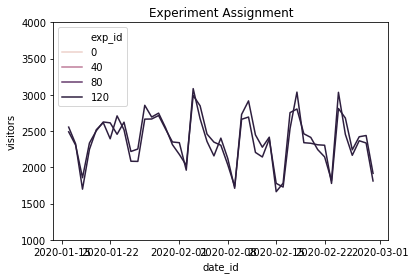

In [8]:
ax = sns.lineplot(data=(first_pageview
                        .fillna(0)
                        .groupby(["date_id", "exp_id"])
                        .agg({"anonymous_id": "count"})
                        .rename(columns={"anonymous_id": "visitors"})
                        .reset_index()),
                  x="date_id",
                  y="visitors",
                  hue="exp_id");
ax.set_ylim((1000,4000));
ax.set_title("Experiment Assignment");

**Remove `exp_id` from data before experiment begin (2020-02-01)**

In [9]:
first_pageview.loc[first_pageview["date_id"] < "2020-02-01", "exp_id"] = np.nan

Text(0.5, 1.0, 'Experiment Assignment')

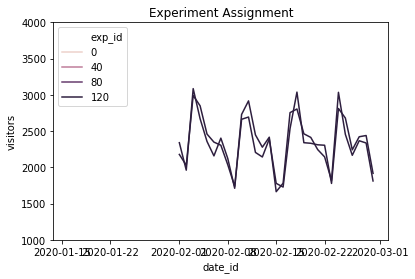

In [10]:
ax = sns.lineplot(data=(first_pageview
                        .fillna(0)
                        .groupby(["date_id", "exp_id"])
                        .agg({"anonymous_id": "count"})
                        .rename(columns={"anonymous_id": "visitors"})
                        .reset_index()),
                  x="date_id",
                  y="visitors",
                  hue="exp_id");
ax.set_ylim((1000,4000));
ax.set_title("Experiment Assignment")

In [11]:
first_pageview["exp_id"].fillna(0).value_counts(normalize=True)

0      0.931430
101    0.034329
102    0.034242
Name: exp_id, dtype: float64

In [12]:
first_pageview.to_csv("data/init/first_pageviews.csv", index=False)

In [13]:
first_pageview.to_csv("data/2020-03-01/first_pageviews.csv", index=False)

**Create subscriptions table**

In [26]:
# get a sample
sample_subscribers = first_pageview.sample(frac=.01014).reset_index(drop=True)

In [27]:
sample_subscribers["exp_id"].fillna(0).value_counts(normalize=True)

0      0.928839
102    0.037052
101    0.034110
Name: exp_id, dtype: float64

In [28]:
# add stochastic 'created_at'
time_to_subscribe = pd.Series(np.random.pareto(3, len(sample_subscribers)) * 30000)

In [29]:
time_to_subscribe = pd.to_timedelta(time_to_subscribe, unit="m")

In [30]:
sample_subscribers = sample_subscribers.assign(tts=time_to_subscribe)

In [31]:
sample_subscribers = sample_subscribers.assign(created_at=sample_subscribers["date_id"] + sample_subscribers["tts"])

In [20]:
sample_subscribers.head()

,date_id,anonymous_id,exp_id,tts,created_at
0,2020-02-02,40c688f1-c252-422c-9d7a-acd5e196dcdf,101,21 days 08:49:02.357362,2020-02-23 08:49:02.357362020
1,2020-02-22,75b4fe58-64f2-4c05-a43a-cd786190a3d4,NaN,1 days 02:23:34.006138,2020-02-23 02:23:34.006138379
2,2020-01-24,e84edbeb-00b0-460c-9b2e-f0f9edc0824f,NaN,11 days 19:04:02.563345,2020-02-04 19:04:02.563345680
3,2020-01-22,b452d163-4ee1-45f7-8305-1ff1b1c23536,NaN,0 days 07:13:23.422204,2020-01-22 07:13:23.422204920
4,2020-01-25,aaf50dce-2fad-499b-aec1-3e51da3dea88,NaN,18 days 20:42:37.821111,2020-02-12 20:42:37.821111180


In [21]:
# create user table
users = sample_subscribers[["anonymous_id"]].assign(user_id=create_anonymous_ids(len(sample_subscribers)))

In [22]:
additional_users = pd.DataFrame({"anonymous_id": create_anonymous_ids(99999),
                                 "user_id": create_anonymous_ids(99999)})

In [23]:
users = pd.concat([users, additional_users])

In [24]:
users.head()

,anonymous_id,user_id
0,40c688f1-c252-422c-9d7a-acd5e196dcdf,e0d5c38c-5900-4958-8113-5c60e51ea10a
1,75b4fe58-64f2-4c05-a43a-cd786190a3d4,ce69b0ba-f86c-45e2-907f-463e7290eecc
2,e84edbeb-00b0-460c-9b2e-f0f9edc0824f,98c58ede-2f57-4674-9b14-ede3d1870ad0
3,b452d163-4ee1-45f7-8305-1ff1b1c23536,74e76e08-470e-4da4-bed3-32b49592b14d
4,aaf50dce-2fad-499b-aec1-3e51da3dea88,ec5e0a40-6600-4c36-917a-698729a5e588


In [25]:
users.to_csv("data/users.csv", index=False)

In [26]:
# translate anonymous_ids to user_ids
subscriptions = (sample_subscribers
                 .merge(users, how="inner", on="anonymous_id")
                 [["user_id", "created_at"]])

In [27]:
# create random client_app column
def create_random_client(sample_size):
    client_app = {"ios": .3,
                  "android": .2}
    
    client_apps = []
    for client, factor in client_app.items():
        client_apps = client_apps + [client for i in range(int(sample_size * factor))]
        
    client_apps = client_apps + ["web" for i in range(int(sample_size - len(client_apps)))]
    random.shuffle(client_apps)
    
    return client_apps

In [28]:
subscriptions = subscriptions.assign(client_app=create_random_client(len(subscriptions)))

In [30]:
subscriptions.head()

,user_id,created_at,client_app
0,e0d5c38c-5900-4958-8113-5c60e51ea10a,2020-02-23 08:49:02.357362020,android
1,ce69b0ba-f86c-45e2-907f-463e7290eecc,2020-02-23 02:23:34.006138379,ios
2,98c58ede-2f57-4674-9b14-ede3d1870ad0,2020-02-04 19:04:02.563345680,web
3,74e76e08-470e-4da4-bed3-32b49592b14d,2020-01-22 07:13:23.422204920,ios
4,ec5e0a40-6600-4c36-917a-698729a5e588,2020-02-12 20:42:37.821111180,android


In [31]:
subscriptions.to_csv("data/subscriptions.csv", index=False)